# Stochastic Mini

#### Fast Deterministic Simulation
Aaron Smith 2025.  
Based on the full **Stochastic 3** simulation

In [1]:
## Import statements ##

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import itertools as itl

In [2]:
## Colours ##

green = "#6dc317"
yellow = "#e8c636"
orange = "#ed7d31"
red = "#d93a15"
purple = "#8c43ed"
blue = "#177add"
black = "#000000"
charcoal = "#2f2f2f"
grey = "#c2c2c2"
white = "#ffffff"
off_white = "#fafafa"

# Colourmaps
spectral = mplcm.Spectral
viridis = mplcm.viridis

#### Single Simulation

Note: testing in progress - change cell growth from linear to exp.

Prev: $$B_{healthy} \rightarrow B_{healthy} * (1 + \frac{dt}{T_{double}})$$

New: $$B_{healthy} \rightarrow B_{healthy} * (e^{\frac{dt*\ln(2)}{T_{double}}})$$

In [3]:
## Define Simulation ##
def run_simulation(B_0, T_double, ads_max, V_wt, tau_wt, beta_wt, V_mu, tau_mu, beta_mu, growth_mode):

    ## Precalculate ln(2) / T_double ##
    ln_2_TD = np.log(2)/T_double

    ## Check burst sizes are non negative ##
    if beta_wt < 0 or beta_mu < 0:
        raise Exception("One of the burst sizes is negative! Please set to zero at minimum.")
    
    ## Cell Growth Mode ##
    def growth_factor(dt):
        if growth_mode in ["linear", "lin"]:
            return(1 + dt/T_double)
        elif growth_mode in ["exponential", "exp"]:
            return(np.exp(dt*ln_2_TD))
        elif growth_mode in ["none"]:
             return(1)
        else:
            raise Exception("Unknown growth_mode argument. Use 'linear', 'exponential' or 'none'.")

    ## Create DataFrame ##
    columns = ["Time (min)", "Process", "Total Cells", "Healthy Cells", "Infected wt", "Free wt", "Next Lysis wt", "Infected mu", "Free mu", "Next Lysis mu", "Total Adsorbed Phages"]
    df = pd.DataFrame(columns = columns)

    ## Record Initial Conditions ##
    df.loc[df.shape[0]] = [0, "Initialise", B_0, B_0, 0, V_wt, 0, 0, V_mu, 0, 0]

    ## Define Wild Type Propagators ##
    def wild_type_burst(dt):
        total_infected = df.at[df.shape[0]-1, "Infected wt"] + df.at[df.shape[0]-1, "Infected mu"]
        if total_infected > 0:
            one_over_total_infected = 1/total_infected
        else:
            one_over_total_infected = 0
        df.loc[df.shape[0]] = [df.at[df.shape[0]-1, "Time (min)"] + dt,
                               "Wt Burst",
                               df.at[df.shape[0]-1, "Total Cells"] - df.at[df.shape[0]-1, "Infected wt"] + df.at[df.shape[0]-1, "Healthy Cells"]*(growth_factor(dt)-1),
                               df.at[df.shape[0]-1, "Healthy Cells"]*growth_factor(dt),
                               0,
                               df.at[df.shape[0]-1, "Infected wt"] * beta_wt + df.at[df.shape[0]-1, "Free wt"],
                               df.at[df.shape[0]-1, "Next Lysis wt"],
                               df.at[df.shape[0]-1, "Infected mu"],
                               df.at[df.shape[0]-1, "Free mu"],
                               df.at[df.shape[0]-1, "Next Lysis mu"],
                               df.at[df.shape[0]-1, "Total Adsorbed Phages"]*(1 - df.at[df.shape[0]-1, "Infected wt"]*one_over_total_infected)]
        return(df)

    def wild_type_adsorb():
        if df.at[df.shape[0]-1, "Total Cells"] > 0:
            P_0 = np.exp(-1*df.at[df.shape[0]-1, "Free wt"] / df.at[df.shape[0]-1, "Total Cells"]) # Probability of a cell having no virions bind = e^-lambda
        else:
            P_0 = 1.0
        df.loc[df.shape[0]] = [df.at[df.shape[0]-1, "Time (min)"],
                               "Wt Adsorb",
                               df.at[df.shape[0]-1, "Total Cells"],
                               df.at[df.shape[0]-1, "Healthy Cells"]*P_0,
                               df.at[df.shape[0]-1, "Healthy Cells"]*(1 - P_0),
                               df.at[df.shape[0]-1, "Free wt"] - np.clip(df.at[df.shape[0]-1, "Total Cells"] * ads_max - df.at[df.shape[0]-1, "Total Adsorbed Phages"], a_min = 0, a_max = df.at[df.shape[0]-1, "Free wt"]),
                               df.at[df.shape[0]-1, "Next Lysis wt"] + tau_wt,
                               df.at[df.shape[0]-1, "Infected mu"],
                               df.at[df.shape[0]-1, "Free mu"],
                               df.at[df.shape[0]-1, "Next Lysis mu"],
                               df.at[df.shape[0]-1, "Total Adsorbed Phages"] + np.clip(df.at[df.shape[0]-1, "Total Cells"] * ads_max - df.at[df.shape[0]-1, "Total Adsorbed Phages"], a_min = 0, a_max = df.at[df.shape[0]-1, "Free wt"])] 
        
        return(df)

    def mutant_burst(dt):
        total_infected = df.at[df.shape[0]-1, "Infected wt"] + df.at[df.shape[0]-1, "Infected mu"]
        if total_infected > 0:
            one_over_total_infected = 1/total_infected
        else:
            one_over_total_infected = 0
        df.loc[df.shape[0]] = [df.at[df.shape[0]-1, "Time (min)"] + dt,
                               "Mu Burst",
                               df.at[df.shape[0]-1, "Total Cells"] - df.at[df.shape[0]-1, "Infected mu"] + df.at[df.shape[0]-1, "Healthy Cells"]*(growth_factor(dt)-1),
                               df.at[df.shape[0]-1, "Healthy Cells"]*growth_factor(dt),
                               df.at[df.shape[0]-1, "Infected wt"],
                               df.at[df.shape[0]-1, "Free wt"],
                               df.at[df.shape[0]-1, "Next Lysis wt"],
                               0,
                               df.at[df.shape[0]-1, "Infected mu"] * beta_mu + df.at[df.shape[0]-1, "Free mu"],
                               df.at[df.shape[0]-1, "Next Lysis mu"],
                               df.at[df.shape[0]-1, "Total Adsorbed Phages"]*(1 - df.at[df.shape[0]-1, "Infected mu"]*one_over_total_infected)]
        return(df)

    def mutant_adsorb():
        if df.at[df.shape[0]-1, "Total Cells"] > 0:
            P_0 = np.exp(-1*df.at[df.shape[0]-1, "Free mu"] / df.at[df.shape[0]-1, "Total Cells"]) # Probability of a cell having no virions bind = e^-lambda
        else:
            P_0 = 1.0
        df.loc[df.shape[0]] = [df.at[df.shape[0]-1, "Time (min)"],
                               "Mu Adsorb",
                               df.at[df.shape[0]-1, "Total Cells"],
                               df.at[df.shape[0]-1, "Healthy Cells"]*P_0,
                               df.at[df.shape[0]-1, "Infected wt"],
                               df.at[df.shape[0]-1, "Free wt"],
                               df.at[df.shape[0]-1, "Next Lysis wt"],
                               df.at[df.shape[0]-1, "Healthy Cells"]*(1 - P_0),
                               df.at[df.shape[0]-1, "Free mu"] - np.clip(df.at[df.shape[0]-1, "Total Cells"] * ads_max - df.at[df.shape[0]-1, "Total Adsorbed Phages"], a_min = 0, a_max = df.at[df.shape[0]-1, "Free mu"]),
                               df.at[df.shape[0]-1, "Next Lysis mu"] + tau_mu,
                               df.at[df.shape[0]-1, "Total Adsorbed Phages"] + np.clip(df.at[df.shape[0]-1, "Total Cells"] * ads_max - df.at[df.shape[0]-1, "Total Adsorbed Phages"], a_min = 0, a_max = df.at[df.shape[0]-1, "Free mu"])] 
        
        return(df)

    def round_off():
        df.loc[df.shape[0]] = [df.at[df.shape[0]-1, "Time (min)"],
                               "Round",
                               round(df.at[df.shape[0]-1, "Total Cells"], 0),
                               round(df.at[df.shape[0]-1, "Healthy Cells"], 0),
                               round(df.at[df.shape[0]-1, "Infected wt"], 0),
                               round(df.at[df.shape[0]-1, "Free wt"], 0),
                               df.at[df.shape[0]-1, "Next Lysis wt"],
                               round(df.at[df.shape[0]-1, "Infected mu"], 0),
                               round(df.at[df.shape[0]-1, "Free mu"], 0),
                               df.at[df.shape[0]-1, "Next Lysis mu"],
                               round(df.at[df.shape[0]-1, "Total Adsorbed Phages"], 0)]

    ## Starting From Initial Conditions, Run Propagators In Correct Order ##

    wild_type_adsorb()
    mutant_adsorb()
    #round_off()

    for step in range(100):
        if df.at[df.shape[0]-1, "Next Lysis wt"] > df.at[df.shape[0]-1, "Next Lysis mu"]:
            dt = df.at[df.shape[0]-1, "Next Lysis mu"] - df.at[df.shape[0]-1, "Time (min)"]
            mutant_burst(dt)
            mutant_adsorb()
            round_off()
            
        elif df.at[df.shape[0]-1, "Next Lysis wt"] < df.at[df.shape[0]-1, "Next Lysis mu"]:
            dt = df.at[df.shape[0]-1, "Next Lysis wt"] - df.at[df.shape[0]-1, "Time (min)"]
            wild_type_burst(dt)
            wild_type_adsorb()
            round_off()
            
        elif df.at[df.shape[0]-1, "Next Lysis wt"] == df.at[df.shape[0]-1, "Next Lysis mu"]:
            print(df)
            raise Exception("Both phages finished a lysis round at the same time!")

        if df.at[df.shape[0]-1, "Total Cells"] <= 0:
            break    # if there are no cells left, break

        if df.at[df.shape[0]-1, "Infected wt"] + df.at[df.shape[0]-1, "Infected mu"] <= 0:
            break    # if there are no infected cells left, break (happens for growth rate zero)

    ## Calculate delta_F (Roughly) ##
    final_wt = df.at[df.shape[0]-1, "Free wt"]
    final_mu = df.at[df.shape[0]-1, "Free mu"]
    final_time = df.at[df.shape[0]-1, "Time (min)"]

    if final_wt <= 0 and final_mu <= 0:
        delta_F = 0    # this should only happen if something goes wrong, e.g. the simulation times out!
    elif final_wt <= 0:
        delta_F = 10
    elif final_mu <= 0:
        delta_F = -10
    else:
        delta_F = np.log(final_mu / final_wt) / final_time


    

    return(df, delta_F)

In [4]:
## Set parameters ##
B_0 = 10_000
T_double = 4
ads_max = 100
growth_mode = "exp"    # "linear", "exponential", or "none".

V_wt = 100
tau_wt = 10
beta_wt = max(0, (tau_wt-15)*20)

V_mu = 100
tau_mu = 20.001
beta_mu = max(0, (tau_mu-15)*20)

In [5]:
data, delta_F = run_simulation(B_0, T_double, ads_max, V_wt, tau_wt, beta_wt, V_mu, tau_mu, beta_mu, growth_mode)

print(delta_F)
data

10


,Time (min),Process,Total Cells,Healthy Cells,Infected wt,Free wt,Next Lysis wt,Infected mu,Free mu,Next Lysis mu,Total Adsorbed Phages
0,0.000,Initialise,1.000000e+04,10000.000000,0.000000,100.0,0,0.000000e+00,1.000000e+02,0.000,0.000000e+00
1,0.000,Wt Adsorb,1.000000e+04,9900.498337,99.501663,0.0,10,0.000000e+00,1.000000e+02,0.000,1.000000e+02
2,0.000,Mu Adsorb,1.000000e+04,9801.986733,99.501663,0.0,10,9.851160e+01,0.000000e+00,20.001,2.000000e+02
3,10.000,Wt Burst,5.554692e+04,55448.410304,0.000000,0.0,10,9.851160e+01,0.000000e+00,20.001,9.950000e+01
4,10.000,Wt Adsorb,5.554692e+04,55448.410304,0.000000,0.0,20,9.851160e+01,0.000000e+00,20.001,9.950000e+01
...,...,...,...,...,...,...,...,...,...,...,...
61,140.000,Wt Adsorb,1.140031e+09,0.000000,0.000000,0.0,150,1.140031e+09,6.016869e+12,140.007,1.140031e+11
62,140.000,Round,1.140031e+09,0.000000,0.000000,0.0,150,1.140031e+09,6.016869e+12,140.007,1.140031e+11
63,140.007,Mu Burst,0.000000e+00,0.000000,0.000000,0.0,150,0.000000e+00,6.130895e+12,140.007,0.000000e+00
64,140.007,Mu Adsorb,0.000000e+00,0.000000,0.000000,0.0,150,0.000000e+00,6.130895e+12,160.008,0.000000e+00


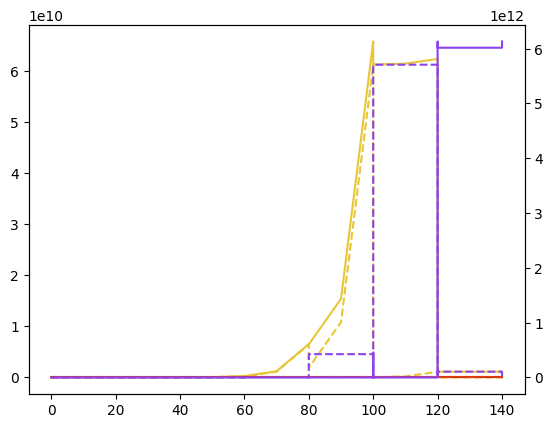

In [6]:
## Plot ##

fig, ax = plt.subplots(1)
ay = ax.twinx()
ax.plot(data["Time (min)"], data["Total Cells"], color = yellow, linestyle = "solid")
ax.plot(data["Time (min)"], data["Healthy Cells"], color = yellow, linestyle = "dashed")
ax.plot(data["Time (min)"], data["Infected wt"], color = red, linestyle = "dashed")
ax.plot(data["Time (min)"], data["Infected mu"], color = purple, linestyle = "dashed")
ay.plot(data["Time (min)"], data["Free wt"], color = red, linestyle = "solid")
ay.plot(data["Time (min)"], data["Free mu"], color = purple, linestyle = "solid")

#### Multiple Simulations

In [7]:
eva1 = np.linspace(1, 50, 201)
eva2 = np.linspace(1+2**(-10), 50+2**(-10), 201)  # slight offset to prevent syncronicity

print(eva1[0], eva1[1], eva1[2], eva1[-1])
print(eva2[0], eva2[1], eva2[2], eva2[-1])

1.0 1.245 1.49 50.0
1.0009765625 1.2459765625 1.4909765625 50.0009765625


In [8]:
dFs = np.zeros([len(eva1), len(eva2)])

In [9]:
## Set parameters ##
name = "Choua Big One (1, 50, 201) [exp]"

B_0 = 10_000
T_double = 20
ads_max = 100
growth_mode = "exponential"    # "linear", "exponential", or "none".

V_wt = 100
V_mu = 100

In [10]:
for i, j, in itl.product(range(len(eva1)), range(len(eva2))):
    ev1, ev2 = eva1[i], eva2[j]
    if i == j:
        delta_F = 0
    else:
        data, delta_F = run_simulation(B_0, T_double, ads_max, V_wt, ev1, max(0, 20*(ev1-9.5)), V_mu, ev2, max(0, 20*(ev2-9.5)), growth_mode)
    dFs[j,i] = delta_F
    print("Running! {},{}/{},{}        ".format(i,j,len(eva1),len(eva2)), end = "\r")

Running! 200,200/201,201        

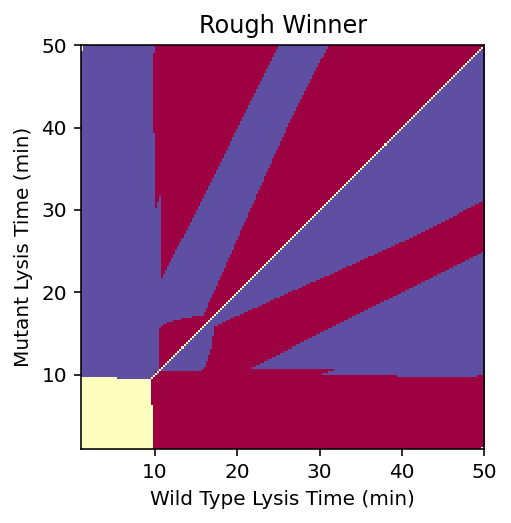

<Figure size 640x480 with 0 Axes>

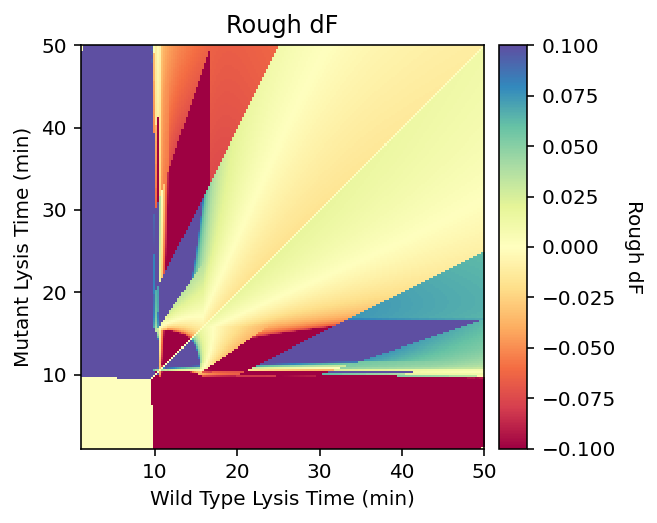

<Figure size 640x480 with 0 Axes>

In [11]:
## Winner ##

fig = plt.figure(figsize=(4,4), dpi = 144)
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])
im = ax.imshow(np.sign(dFs), cmap = spectral, origin = "lower", interpolation = "none",
               norm = "linear", vmin = -0.1, vmax = 0.1,
               extent = [min(eva1), max(eva1), min(eva2), max(eva2)])

ax.set_xlabel("Wild Type Lysis Time (min)")
ax.set_ylabel("Mutant Lysis Time (min)")
ax.set_title("Rough Winner")

plt.savefig(name + "Rough Winner.png")
plt.show()
plt.clf()

## delta F ##

fig = plt.figure(figsize=(4,4), dpi = 144)
ax = fig.add_axes([0.1, 0.1, 0.7, 0.7])
cax = fig.add_axes([0.825, 0.1, 0.05, 0.7])
im = ax.imshow(dFs, cmap = spectral, origin = "lower", interpolation = "none",
               norm = "linear", vmin = -0.1, vmax = 0.1,
               extent = [min(eva1), max(eva1), min(eva2), max(eva2)])

cbar = ax.figure.colorbar(im, cax = cax)
cbar.outline.set_visible(True)
cbar.ax.set_ylabel("Rough dF", rotation=-90, va="bottom")

ax.set_xlabel("Wild Type Lysis Time (min)")
ax.set_ylabel("Mutant Lysis Time (min)")
ax.set_title("Rough dF")

plt.savefig(name + "Rough dF.png")
plt.show()
plt.clf()